In [1]:
import requests
import io
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, recall_score, precision_score, f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV

from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_keys(path):
    with open(path) as f:
        return f.readlines()[0]

In [3]:
def get_historical_stock_price(ticker, interval = None, startDate = None, endDate = None):
    url = 'https://api.unibit.ai/v2/stock/historical?'

    ticker_dict = {
        'tickers' : ticker,
        'interval' : interval,
        'startDate' : startDate,
        'endDate' : endDate,
        'selectedFields' : None,
        'dataType':'json',
        'accessKey': get_keys('C:\\Users\\TJ Bray\.secret\\unibit.txt')
    }
    
    response = requests.get(url, params = ticker_dict)
    data = response.json()['result_data'][ticker]
    df = pd.json_normalize(data)
    
    return df

In [4]:
#NKE = get_historical_stock_price('NKE', startDate = '2021-1-1', endDate = '2022-1-7')
#NKE.to_csv('nike.csv')

In [5]:
#nike = pd.read_csv('nike.csv', index_col = 0)
#nike.date = pd.to_datetime(nike.date)
#nike.set_index('date', inplace = True)
#nike.sort_index(inplace = True)

In [6]:
#files = [f for f in listdir('.\S&P500_data')]

In [7]:
#companies = []
#for i in files:
    #company = i.split('.')[0]
    #companies.append(company)

In [8]:
#test_companies = np.random.choice(companies, 5)

In [9]:
#x = test_companies[0]
x = 'AAPL'

In [10]:
csv_for_df = f'S&P500_data/{x}.csv'
df = pd.read_csv(csv_for_df)
df.columns = [i.lower().replace(' ',"") for i in df.columns]

In [11]:
df['date'] = pd.to_datetime(df.date, format = '%d-%m-%Y')
df.set_index('date', inplace = True)
df.sort_index(inplace = True)

In [12]:
df['rsi'] = ta.rsi(df.close)

In [13]:
def add_bbands(df):
    bbands = ta.bbands(df.close)
    df = df.join(bbands)
    return df

bbands_df = add_bbands(df)

In [14]:
def add_sma(df):
    
    sma_days = [7,22,252]
    
    for i in sma_days:
        name = f'sma{i}'
        df[name] = ta.sma(df['close'],i)
        
    return df

In [15]:
sma_df = add_sma(bbands_df)

In [16]:
def add_ema(df):

    ema_days = [7,22,252]

    for i in ema_days:
        name = f'ema{i}'
        df[name] = ta.ema(df['close'],i)
        
    for i in ema_days:
        zone_name = f'ema{i}zone'
        df[zone_name] = ta.ema(df.high,i) - ta.ema(df.low,i)
        
    return df

In [17]:
ema_df = add_ema(sma_df)

In [18]:
df = ema_df

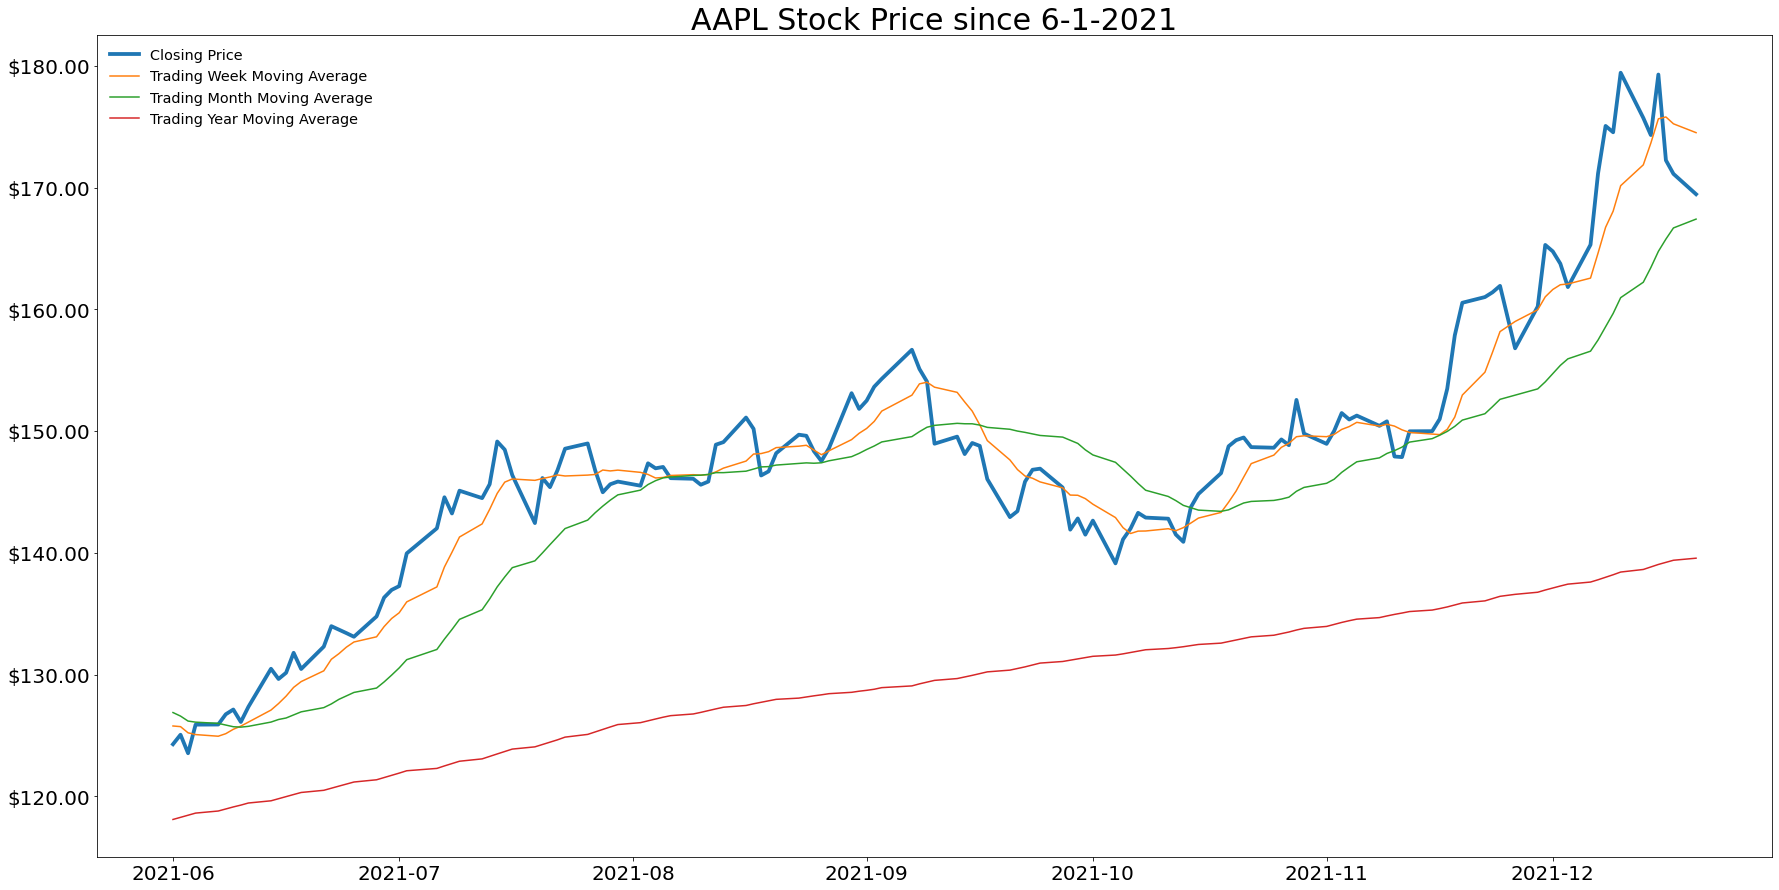

In [19]:
date = '6-1-2021'
title = f'{x} Stock Price since {date}'

plotdata = df[df.index >= date]
fig, ax = plt.subplots(figsize = (24,12))
plt.tight_layout()
ax.plot(plotdata.close, linewidth = 3.8)
ax.plot(plotdata.sma7)
ax.plot(plotdata.sma22)
ax.plot(plotdata.sma252)
ax.yaxis.set_major_formatter('${x:1,.2f}')
ax.legend(['Closing Price', 'Trading Week Moving Average', 'Trading Month Moving Average', 'Trading Year Moving Average'],
         fontsize = 'x-large', edgecolor = '1')
ax.set_title(title, fontsize = '30')
plt.xticks(fontsize = '20')
plt.yticks(fontsize = '20')
plt.show()

In [20]:
lags = [1,2,3,4,5,10]

for i in lags:
    lag_time = f'closelag{i}'
    df[lag_time] = df['adjustedclose'].shift(i)

In [21]:
df.dropna(inplace = True)

In [32]:
df['log_volume'] = np.log(df.volume)
df.drop('volume', axis = 1)

,low,open,high,close,adjustedclose,rsi,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,...,ema7zone,ema22zone,ema252zone,closelag1,closelag2,closelag3,closelag4,closelag5,closelag10,log_volume
date,,,,,,,,,,,,,,,,,,,,,
1981-12-10,0.084263,0.084263,0.084821,0.084263,0.065950,51.836093,0.083348,0.084486,0.085624,2.694168,...,0.000641,0.000622,0.000709,0.065950,0.065513,0.066823,0.066386,0.064640,0.064203,17.437395
1981-12-11,0.083705,0.084263,0.084821,0.083705,0.065513,50.298559,0.083040,0.084263,0.085486,2.901663,...,0.000760,0.000665,0.000712,0.065950,0.065950,0.065513,0.066823,0.066386,0.065950,18.147464
1981-12-14,0.080915,0.082031,0.082031,0.080915,0.063329,43.371417,0.080865,0.083370,0.085876,6.010337,...,0.000849,0.000704,0.000715,0.065513,0.065950,0.065950,0.065513,0.066823,0.065076,17.044131
1981-12-15,0.083147,0.083147,0.083705,0.083147,0.065076,49.377808,0.080773,0.083259,0.085744,5.970436,...,0.000776,0.000692,0.000714,0.063329,0.065513,0.065950,0.065950,0.065513,0.065076,17.259614
1981-12-16,0.087054,0.087054,0.087612,0.087054,0.068134,57.812931,0.079861,0.083817,0.087773,9.439087,...,0.000722,0.000680,0.000713,0.065076,0.063329,0.065513,0.065950,0.065950,0.065513,17.996840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-14,172.210007,175.250000,177.740005,174.330002,174.330002,67.396163,172.086299,175.832001,179.577703,4.260546,...,5.041142,4.246738,2.837899,175.740005,179.449997,174.559998,175.080002,171.179993,165.300003,18.752717
2021-12-15,172.309998,175.110001,179.500000,179.300003,179.300003,71.851111,172.164885,176.676001,181.187117,5.106654,...,5.578357,4.502674,2.872303,174.330002,175.740005,179.449997,174.559998,175.080002,164.770004,18.691191
2021-12-16,170.750000,179.279999,181.139999,172.259995,172.259995,59.457876,170.601494,176.216000,181.830507,6.372300,...,6.781268,5.014615,2.931731,179.300003,174.330002,175.740005,179.449997,174.559998,163.759995,18.827384


In [33]:
X = df.drop(['close','adjustedclose'], axis = 1).shift(1)
y = df['adjustedclose']
y['direction'] = np.where(y > y.shift(1),1,0)
y = y['direction']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

X_train.shape, X_test.shape

((8074, 26), (2019, 26))

In [35]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [36]:
def feature_select(X_train,y_train,estimator,min_features,step=1):
    estimator=estimator()
    selector=RFECV(estimator,min_features_to_select=min_features,step=step)
    selector.fit(X_train,y_train)
    selector.ranking_
    feature_dict=dict(zip(X_train.columns, selector.ranking_))
    best_pred = [k for (k,v) in feature_dict.items() if v == 1]
    
    return best_pred

In [37]:
logreg_feat=feature_select(X_train_scaled,y_train,LogisticRegression,min_features=10)
X_train_best_log = X_train_scaled[logreg_feat]
X_test_best_log = X_test_scaled[logreg_feat]